IMPORTS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score,  classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Importando os conjuntos da base de dados

In [ ]:
test_path = "../test_normalized.csv"
val_path = "../val_normalized.csv"
subtrain_path = "../train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=None)
df_test = pd.read_csv(test_path, index_col=None)
df_subtrain = pd.read_csv(subtrain_path, index_col=None)

In [3]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (12600, 22)
Teste: (18900, 22)
Sub-conjunto de treinamento (13500, 22)


In [ ]:
X_train_subset = df_subtrain.drop(columns=["loan_status"])
y_train_subset  = df_subtrain["loan_status"]

X_val = df_val.drop(columns=["loan_status"])
y_val = df_val["loan_status"]

X_test = df_test.drop(columns=["loan_status"])
y_test = df_test["loan_status"]

# Unificando os conjuntos de subtreino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)
y_train= pd.concat([y_train_subset, y_val], axis=0)

# Achando os melhores hiperparâmetros

In [5]:
# Modelos base
base_models = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('lightgbm', lgb.LGBMClassifier())
]

# Modelo meta
meta_model = LogisticRegression()

# Parâmetros para o RandomizedSearchCV
param_dist = {
    'final_estimator__C': [0.01, 0.1, 1, 10], 
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'saga'],
}

# Testar ambas as versões de stack_method
metodos = ['predict_proba', 'predict']
resultados = {}

for metodo in metodos:
    print(f"\n🔍 Testando stack_method='{metodo}'...")
    
    # Criar o modelo Stacking com o stack_method atual
    modelo_stacking = StackingClassifier(
        estimators=base_models, 
        final_estimator=meta_model, 
        passthrough=True,
        stack_method=metodo
    )

    # Listas para armazenar os resultados
    melhores_modelos = []
    historico_mean_scores = []
    historico_std_scores = []
    historico_acuracia_val = []

    # Executar o RandomizedSearchCV 20 vezes
    for i in range(20):
        print(f"Executando RandomizedSearchCV {i+1}/20...")

        random_search = RandomizedSearchCV(
            modelo_stacking,
            param_distributions=param_dist,
            n_iter=1,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1,
            random_state=i,
            scoring='accuracy',
            return_train_score=True
        )

        random_search.fit(X_train_subset, y_train_subset)

        # Média e desvio-padrão das 5 folds na validação cruzada
        mean_scores = random_search.cv_results_['mean_test_score']
        std_scores = random_search.cv_results_['std_test_score']

        historico_mean_scores.append(np.mean(mean_scores))
        historico_std_scores.append(np.mean(std_scores))

        # Melhor modelo encontrado na iteração atual
        melhor_modelo = random_search.best_estimator_

        # Avaliar o melhor modelo no conjunto de validação
        y_val_pred = melhor_modelo.predict(X_val)
        acuracia_val = accuracy_score(y_val, y_val_pred)

        melhores_modelos.append(melhor_modelo)
        historico_acuracia_val.append(acuracia_val)

    # Escolher o melhor modelo baseado na melhor acurácia no conjunto de validação
    indice_melhor = np.argmax(historico_acuracia_val)
    melhor_modelo_final = melhores_modelos[indice_melhor]

    print(f"\n🔹 stack_method={metodo}")
    print(f"Melhor acurácia no conjunto de validação: {historico_acuracia_val[indice_melhor]:.4f}")
    print(f"🌟 Melhores parâmetros encontrados: {random_search.best_params_}")

    # Armazenar os melhores resultados dessa versão
    resultados[metodo] = {
        "melhor_modelo": melhor_modelo_final,
        "melhores_hiperparâmetros": random_search.best_params_,
        "melhor_acuracia": historico_acuracia_val[indice_melhor]
    }

# Comparação final
print("\n📊 Comparação final entre stack_methods:")
for metodo, res in resultados.items():
    print(f"\n🔹 stack_method={metodo}")
    print(f"Melhor Acurácia: {res['melhor_acuracia']:.4f}")
    print(f"Melhores Hiperparâmetros: {res['melhores_hiperparâmetros']}")



🔍 Testando stack_method='predict_proba'...
Executando RandomizedSearchCV 1/20...


C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Executando RandomizedSearchCV 2/20...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Executando RandomizedSearchCV 7/20...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Executando RandomizedSearchCV 12/20...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Executando RandomizedSearchCV 14/20...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Executando RandomizedSearchCV 18/20...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔹 stack_method=predict_proba
Melhor acurácia no conjunto de validação: 0.9179
🌟 Melhores parâmetros encontrados: {'final_estimator__solver': 'saga', 'final_estimator__penalty': 'l1', 'final_estimator__C': 1}

🔍 Testando stack_method='predict'...
Executando RandomizedSearchCV 1/20...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Executando RandomizedSearchCV 18/20...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔹 stack_method=predict
Melhor acurácia no conjunto de validação: 0.9175
🌟 Melhores parâmetros encontrados: {'final_estimator__solver': 'saga', 'final_estimator__penalty': 'l1', 'final_estimator__C': 1}

📊 Comparação final entre stack_methods:

🔹 stack_method=predict_proba
Melhor Acurácia: 0.9179
Melhores Hiperparâmetros: {'final_estimator__solver': 'saga', 'final_estimator__penalty': 'l1', 'final_estimator__C': 1}

🔹 stack_method=predict
Melhor Acurácia: 0.9175
Melhores Hiperparâmetros: {'final_estimator__solver': 'saga', 'final_estimator__penalty': 'l1', 'final_estimator__C': 1}


Plot e resultados da busca de hiperparâmetros

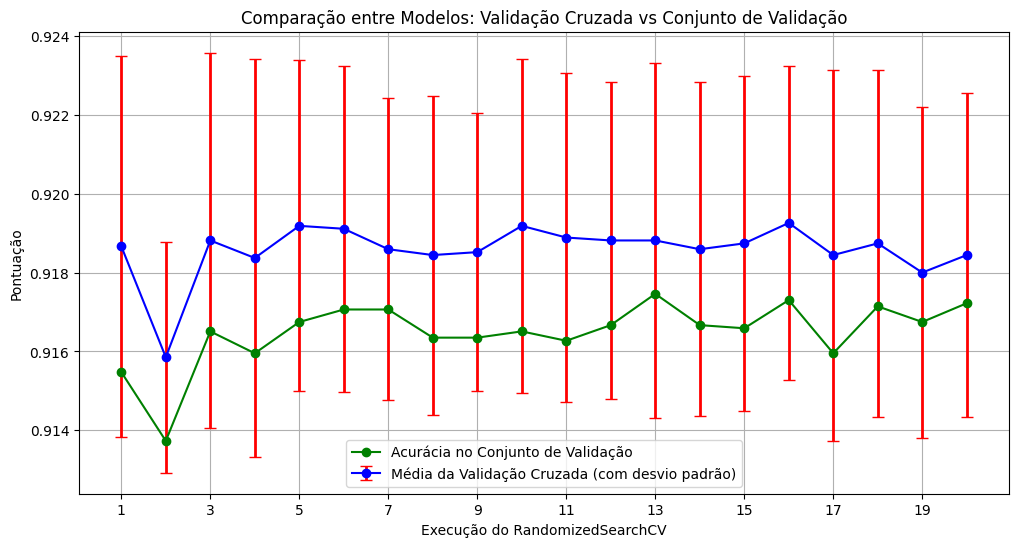

In [6]:
# Criando gráfico com duas linhas
plt.figure(figsize=(12, 6))

# Linha azul: Média da validação cruzada + barras de erro (desvio padrão)
plt.errorbar(
    range(1, len(historico_mean_scores) + 1), 
    historico_mean_scores, 
    yerr=historico_std_scores, 
    fmt='o-',  
    color='b', 
    ecolor='r',  
    elinewidth=2, 
    capsize=4, 
    label='Média da Validação Cruzada (com desvio padrão)'
)

# Linha verde: Acurácia do modelo no conjunto de validação
plt.plot(
    range(1, len(historico_acuracia_val) + 1), 
    historico_acuracia_val, 
    'g-o',  
    label='Acurácia no Conjunto de Validação'
)

# Adicionando título e rótulos
plt.xlabel('Execução do RandomizedSearchCV')
plt.ylabel('Pontuação')
plt.title('Comparação entre Modelos: Validação Cruzada vs Conjunto de Validação')
plt.xticks(range(1, len(historico_mean_scores) + 1, max(1, len(historico_mean_scores) // 10)))  # Ajusta os ticks
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.show()

# Treinando e testando o modelo

In [ ]:
# Seleciona o melhor modelo
melhor_metodo = max(resultados, key=lambda m: resultados[m]['melhor_acuracia'])
melhor_modelo_final = resultados[melhor_metodo]['melhor_modelo']

# Treina o modelo
melhor_modelo_final.fit(X_train, y_train)

# Previsões no conjunto de treinamento
y_train_pred = melhor_modelo_final.predict(X_train)

# Previsões no conjunto de teste
y_test_pred = melhor_modelo_final.predict(X_test)

# Calcula as métricas para treinamento
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='macro') 
recall_train = recall_score(y_train, y_train_pred, average='macro') 
f1_train = f1_score(y_train, y_train_pred, average='macro')

# Calcula as métricas para teste
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='macro') 
recall_test = recall_score(y_test, y_test_pred, average='macro') 
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Exibir os valores no console
print("Métricas no conjunto de Treinamento:")
print(f"Acurácia: {accuracy_train:.4f}")
print(f"Precisão: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")

print("\nMétricas no conjunto de Teste:")
print(f"Acurácia: {accuracy_test:.4f}")
print(f"Precisão: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 26100, number of used features: 21
[LightGBM] [Info] Start training from score -7.771795
[LightGBM] [Info] Start training from score -0.206473
[LightGBM] [Info] Start training from score -1.681308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 20880, number of used features: 21
[LightGBM] [Info] Start training from score -7.749322
[LightGBM] [Info] Start training from score -0.206520
[LightGBM] [I

C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Acurácia: 0.9197
Precisão: 0.5864
Recall: 0.5668
F1-Score: 0.5759


C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Comparando o teste e o treinamento

In [1]:
metricas = ["Acurácia", "Precisão", "Recall", "F1-Score"]
valores_treino = [accuracy_train, precision_train, recall_train, f1_train]
valores_teste = [accuracy_test, precision_test, recall_test, f1_test]

x = np.arange(len(metricas))
largura = 0.3

plt.figure(figsize=(8, 5))
plt.bar(x - largura/2, valores_treino, largura, label="Treinamento", color="blue")
plt.bar(x + largura/2, valores_teste, largura, label="Teste", color="orange")

plt.xlabel("Métricas")
plt.ylabel("Valores")
plt.title("Comparação das métricas entre Treinamento e Teste")
plt.xticks(x, metricas)
plt.legend()
plt.ylim(0, 1)

# Exibir valores nas barras
for i in range(len(metricas)):
    plt.text(i - largura/2, valores_treino[i] + 0.02, f"{valores_treino[i]:.2f}", ha='center', fontsize=10)
    plt.text(i + largura/2, valores_teste[i] + 0.02, f"{valores_teste[i]:.2f}", ha='center', fontsize=10)

plt.show()

NameError: name 'accuracy_train' is not defined

Matriz de confusão


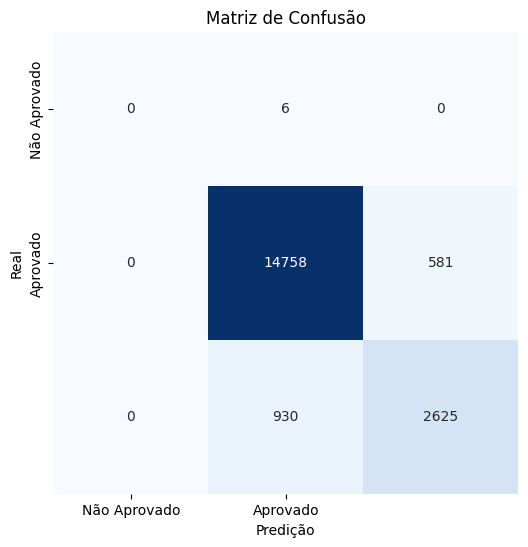

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Aprovado', 'Aprovado'], yticklabels=['Não Aprovado', 'Aprovado'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()